In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

# Reading the first few rows of the CSV fileone 
depth4_19 = '/Users/ron/Code/master_thesis/results/stats_2023-11-24 03:51:18.452267.csv'
depth4_29 = '/Users/ron/Code/master_thesis/results/stats_2023-12-01 17:07:39.195518.csv'
depth4_inference_all_after_training_on_19 = '/Users/ron/Code/master_thesis/results/stats_2023-11-30 11:14:48.912478.csv'
depth4_inference_all_after_training_on_29 = '/Users/ron/Code/master_thesis/results/stats_2023-12-04 19:37:08.204531.csv'
depth3_inference_all_trained_on_4_tasks = '/Users/ron/Code/master_thesis/results/stats_2023-11-29 13:38:47.483420.csv'
depth3_trained_on_4_tasks = '/Users/ron/Code/master_thesis/results/stats_2023-11-29 11:24:58.566967.csv'
depth3_trained_on_4_tasks_inference_37_tasks = '/Users/ron/Code/master_thesis/results/stats_2023-11-29 13:24:37.473425.csv'

# Utils

In [2]:
# Frequency of Program Creation per Task
def program_creation_frequency(data):
    return data.groupby(['Task Name', 'Program']).size().reset_index(name='Frequency')

# Unique Programs per Task
def total_program_variations(data):
    grouped = data.groupby('Task Name')['Program'].nunique()
    return grouped.reset_index(name='Frequency')

# Number of Unique Programs per Task
def program_variations(data):
    return data.groupby('Task Name')['Program'].nunique()

# Variation in Solutions
def solution_variations(data):
    solved_data = data[data['Solved'] == True]
    return solved_data.groupby('Task Name')['Program'].nunique()

# Unique tasks in training
def unique_train_tasks(data):
    return data[data['Mode'] == 'e-step']['Task Name'].unique()

# Unique 
def unique_solved(data):
    return data[data['Solved'] == True]['Task Name'].unique()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

filepath='/Users/ron/Code/master_thesis/report/LaTeX/img'

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Function to create a histogram for program creation frequency per task
# This answers the question: how often were programs resampled to no avail
def plot_program_creation_frequency(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='Frequency', bins=80)
    plt.title('Histogram of Program Creation Frequency')
    plt.xlabel('Frequency')
    plt.ylabel('Count')
    plt.savefig(join(filepath, 'plot_program_creation_frequency.png'))
    plt.show()

# Function to create a bar chart for program rate per task
# This answers the question: how many unique programs were created
def plot_program_variations(data):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar')
    plt.title('Variation in Programs per Task')
    plt.xlabel('Task Name')
    plt.ylabel('Number of Unique Programs')
    plt.xticks(rotation=90)
    plt.savefig(join(filepath, 'plot_program_variations.png'))
    plt.show()

# Function to create a bar chart for variation in solutions
# This answers the question: how many unique solutions were found
def plot_solution_variations(data):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar')
    plt.title('Variation in Solutions per Task')
    plt.xlabel('Task Name')
    plt.ylabel('Number of Unique Solutions')
    plt.xticks(rotation=90)
    plt.savefig(join(filepath, 'plot_solution_variations.png'))
    plt.show()

# Training

In [37]:
data = pd.read_csv('/Users/ron/Code/master_thesis/results/depth_3_48_tasks2023-12-07 11:37:27.csv')
# data = data[data['Mode'] != 'inference']

train_tasks = unique_train_tasks(data)
print(f'Trained on {len(train_tasks)} unique tasks:')
for t in train_tasks:
    print(f'\t{t}')

unique_solved_ = unique_solved(data)
print(f'solved {len(unique_solved_)} unique tasks.')
for t in unique_solved_:
    print(f'\t{t}')

inference = data[data['Mode'] == 'inference']
print(inference[inference['Solved'] == True]['Task Name'].unique())

Trained on 4 unique tasks:
	take-k with k=2
	keep-mod-head
	mult-k with k=3
	prepend-k with k=3
solved 2 unique tasks.
	mult-k with k=3
	prepend-k with k=3
['prepend-k with k=3']


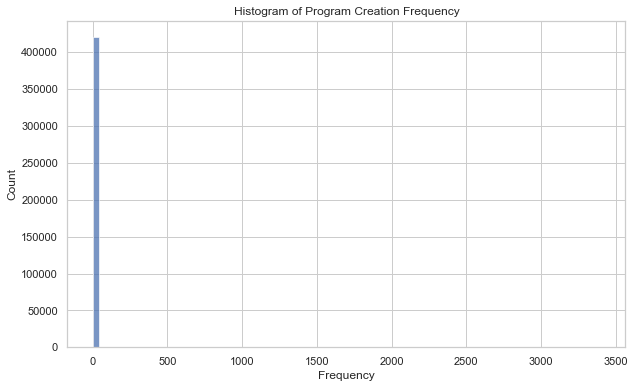

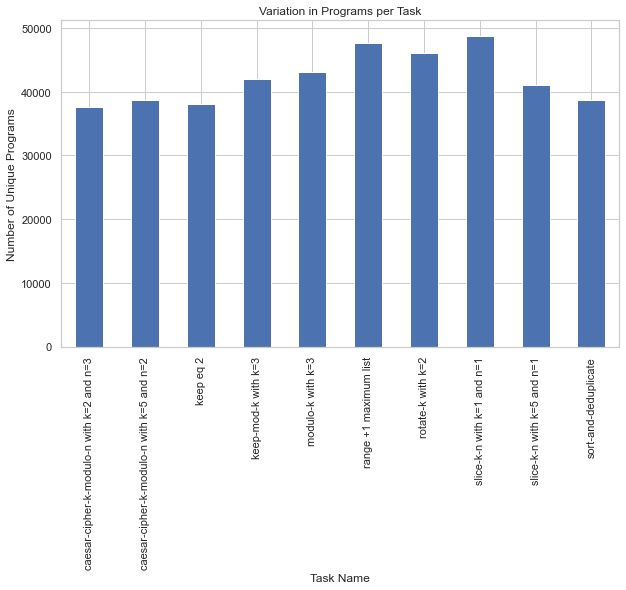

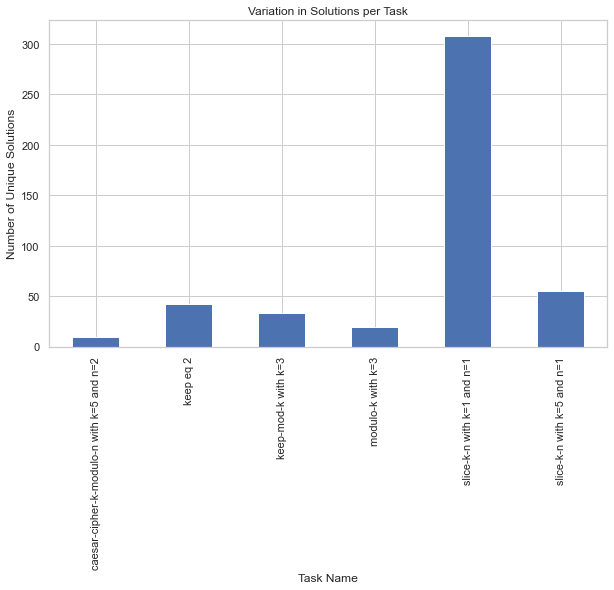

In [5]:
# Execute the functions and display the results
program_freq = program_creation_frequency(data)
program_vars = program_variations(data)
solution_vars = solution_variations(data)

# Plotting the visualizations
plot_program_creation_frequency(program_freq)
plot_program_variations(program_vars)
plot_solution_variations(solution_vars)

### Analysing the EM cycles
- Does the model improve with E-M cycles?
- do we find more solutions in later cycles?
- is the EM necessary? beneficial?

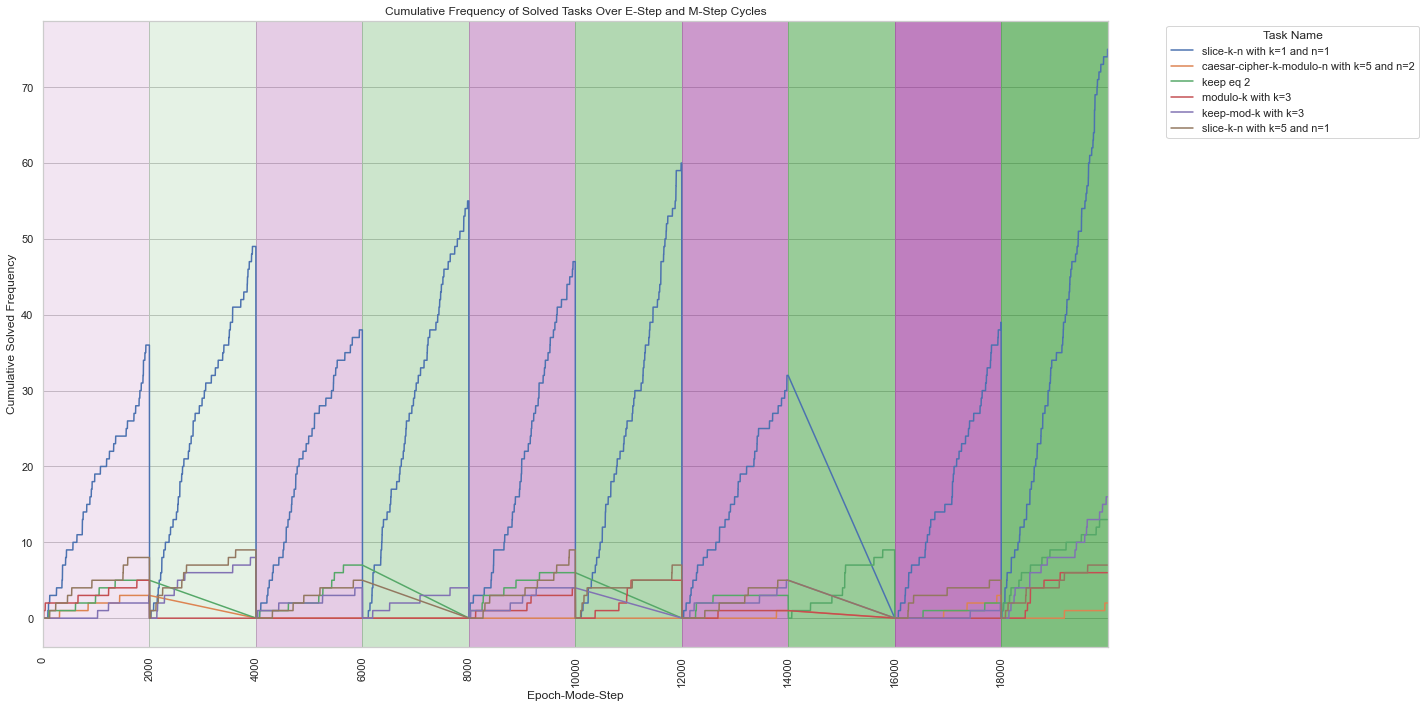

In [6]:
# First, determine the total number of steps in each mode across all epochs
total_e_steps = data[(data['Mode'] == 'e-step')]['Steps'].max() + 1  # Adding 1 because 'Steps' starts from 0
total_m_steps = data[(data['Mode'] == 'm-step')]['Steps'].max() + 1
total_steps_per_epoch = total_e_steps + total_m_steps

# Now, create a new column 'Total Steps' that will accumulate steps across epochs and modes
data['Total Steps'] = data['Epoch'] * (total_e_steps + total_m_steps) + \
                      data['Steps'] + \
                      np.where(data['Mode'] == 'm-step', total_e_steps, 0)

# We are only analysing training data here, so this is just an assertion
data = data[data['Mode'] != 'inference']

# Now filter out tasks that have never been solved
solved_tasks = data[data['Solved'] == True]['Task Name'].unique()
filtered_data = data[data['Task Name'].isin(solved_tasks)]

# Group and count solved instances, then calculate the cumulative sum
solved_frequency = filtered_data.groupby(['Task Name', 'Epoch', 'Mode', 'Total Steps']).agg({'Solved': 'sum'}).reset_index()

solved_frequency['Cumulative Solved'] = solved_frequency.groupby(['Task Name', 'Epoch', 'Mode'])['Solved'].cumsum()

# Now plot the data using 'Total Steps' as the x-axis
plt.figure(figsize=(20, 10))

# Plot a line for each task
for task in solved_tasks:
    task_data = solved_frequency[solved_frequency['Task Name'] == task]
    plt.plot(task_data['Total Steps'], task_data['Cumulative Solved'], label=task)

# Get the total steps for all epochs and set the x-ticks
num_epochs = int(solved_frequency['Epoch'].max() + 1)
total_steps = total_steps_per_epoch * num_epochs

# Set the x-ticks to show e-step and m-step intervals
plt.xticks(np.arange(0, total_steps, total_steps_per_epoch//2), np.arange(0, total_steps, total_steps_per_epoch//2), rotation=90)


# Fill the background color for e-step and m-step intervals
for epoch in range(num_epochs):
    start_e_step = epoch * total_steps_per_epoch
    end_e_step = start_e_step + total_e_steps
    start_m_step = end_e_step
    end_m_step = start_m_step + total_m_steps

    alpha = 0.1 + (epoch * 0.1)  # Adjust alpha for varying shades
    plt.axvspan(start_e_step, end_e_step, color='purple', alpha=alpha, lw=0)
    plt.axvspan(start_m_step, end_m_step, color='green', alpha=alpha, lw=0)

# Ensure the plot includes the last m-step
plt.xlim(0, total_steps)

# Adjusting plot features for clarity
plt.title('Cumulative Frequency of Solved Tasks Over E-Step and M-Step Cycles')
plt.xlabel('Epoch-Mode-Step')
plt.ylabel('Cumulative Solved Frequency')
plt.legend(title='Task Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

# Inference

In [7]:

data = pd.read_csv(depth3_inference_all_trained_on_4_tasks)

n_tasks = data['Task Name'].unique()
print(f'Inference on {len(n_tasks)} unique tasks:')

unique_solved_ = unique_solved(data)
print(f'solved {len(unique_solved_)} unique tasks.')
print(unique_solved_)

Inference on 145 unique tasks:
solved 11 unique tasks.
['add-k with k=1' 'append-k with k=0' 'pow-k with k=3' 'pow-k with k=4'
 'prepend-k with k=4' 'append-k with k=2' 'append-k with k=1'
 'append-k with k=3' 'append-k with k=4' 'drop-k with k=1'
 'append-k with k=5']


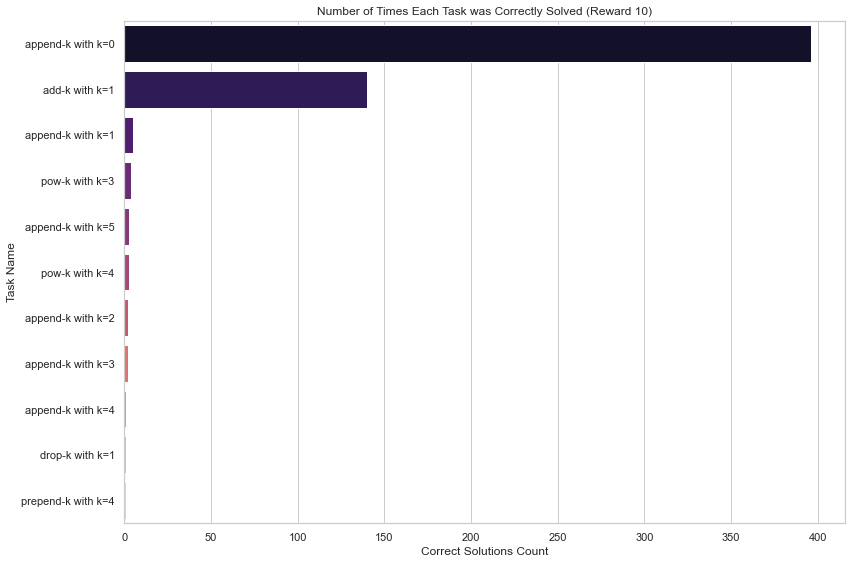

In [8]:
# Filtering the dataset for instances where the reward is 10
correct_solutions = data[data['Reward'] == 10]

# Grouping the data by 'Task Name' and counting occurrences
correct_solutions_count = correct_solutions.groupby('Task Name').size().reset_index(name='Correct Solutions Count')

# Sorting the data for better visualization
correct_solutions_count_sorted = correct_solutions_count.sort_values(by='Correct Solutions Count', ascending=False)

# Creating a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=correct_solutions_count_sorted, x='Correct Solutions Count', y='Task Name', palette="magma")
plt.title('Number of Times Each Task was Correctly Solved (Reward 10)')
plt.xlabel('Correct Solutions Count')
plt.ylabel('Task Name')
plt.tight_layout()

# Showing the plot
plt.show()

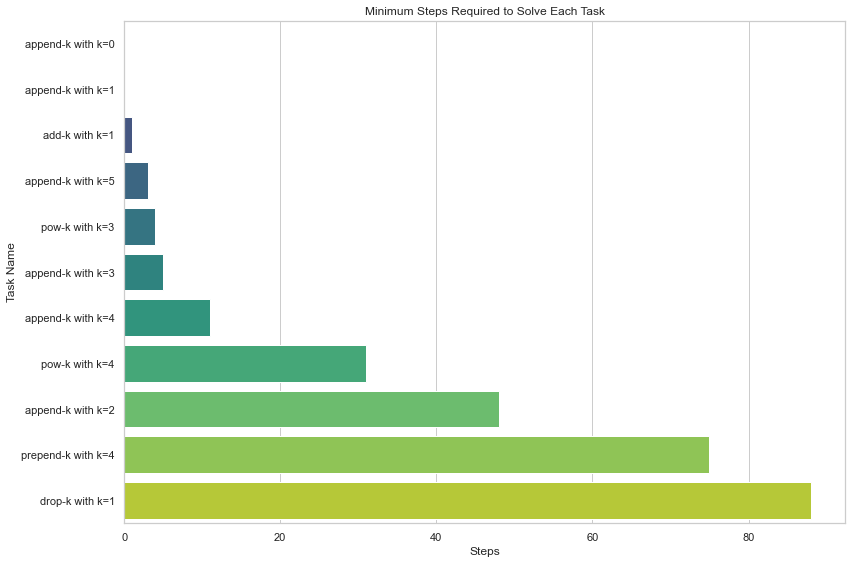

In [9]:
# Filtering the data to include only the tasks that were solved
solved_tasks = data[data['Solved'] == True]

# Grouping the data by 'Task Name' and finding the minimum number of steps for each solved task
steps_per_task = solved_tasks.groupby('Task Name')['Steps'].min().reset_index()

# Sorting the data for better visualization
steps_per_task_sorted = steps_per_task.sort_values(by='Steps')

# Creating a bar plot to show the number of steps for each solved task
plt.figure(figsize=(12, 8))
sns.barplot(data=steps_per_task_sorted, x='Steps', y='Task Name', palette="viridis")
plt.title('Minimum Steps Required to Solve Each Task')
plt.xlabel('Steps')
plt.ylabel('Task Name')
plt.tight_layout()

# Showing the plot
plt.show()


# Embeddings

In [28]:
import torch
# from flowcoder.data import Data

# model = torch.load()

# data = Data(
#     max_program_depth=3,
#     shuffle_tasks=True,
#     n_tasks=145,  # if variable_batch is true, make sure you have enough tasks for the batch_size
#     variable_batch=False,  # if False, all tasks in the batch will be the same
#     train_ratio=0.5,
#     seed=3
#     )

: 